# EVAL Problem 1
In this EVAL problem, we will study the impact of the workload created by the client on our monitored hardware counters in our image server.

In [140]:
# Import Packages
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

-----
a) For this part, we are interested in the observing distribution of the instruction count for various requests and how that relates to request length.

Here, it is immediately important to remember that your results might wildly vary when you compare them with those obtained by your colleagues, because you will be running your code on very different
machines. The only good point is that now you can compete with your friends about who has the best machine!

To carry out these experiments, run the following command:

`./build/server_img_perf -q 1000 -h INSTR 2222 & ./build/client -a 30 -I images/ -n 1000 2222`

(NOTE: if your machine is too weak—#noshame—and starts rejecting requests with the parameters above, you can reduce the arrival rate of requests sent by the client, but keep the same total number `-n 500`).

Now, let’s create a plot comparing the length of the request and the collected instruction count for each of the six different image operations. First, split the collected data by the requested image operation (excluding REGISTER). Each operation’s data will be plotted in it’s own subplot.

In each subplot, create a scatter plot where instruction count is on the x-axis and request length on the y-axis. Keep each plot small enough so that you can fit all of them in a single page, maybe 3 plots per row. Then, create a line of best fit for each of the data plots (i.e. via linear regression).

Again, as in the hw6 eval, I strongly encourage you not to generate each plot manually, but rather use some form of scripting.

Now look at the plots, and answer the following: (1) What is the relationship between instruction count and request length as reported by your line of best fit? (2) Do different image operations behave
differently in terms of their instruction counts and time? Answer this question by comparing the characteristics of your linear regression. (3) If the observed relationship is not linear, what could cause any noise, or discrepency between instruction count and request length?

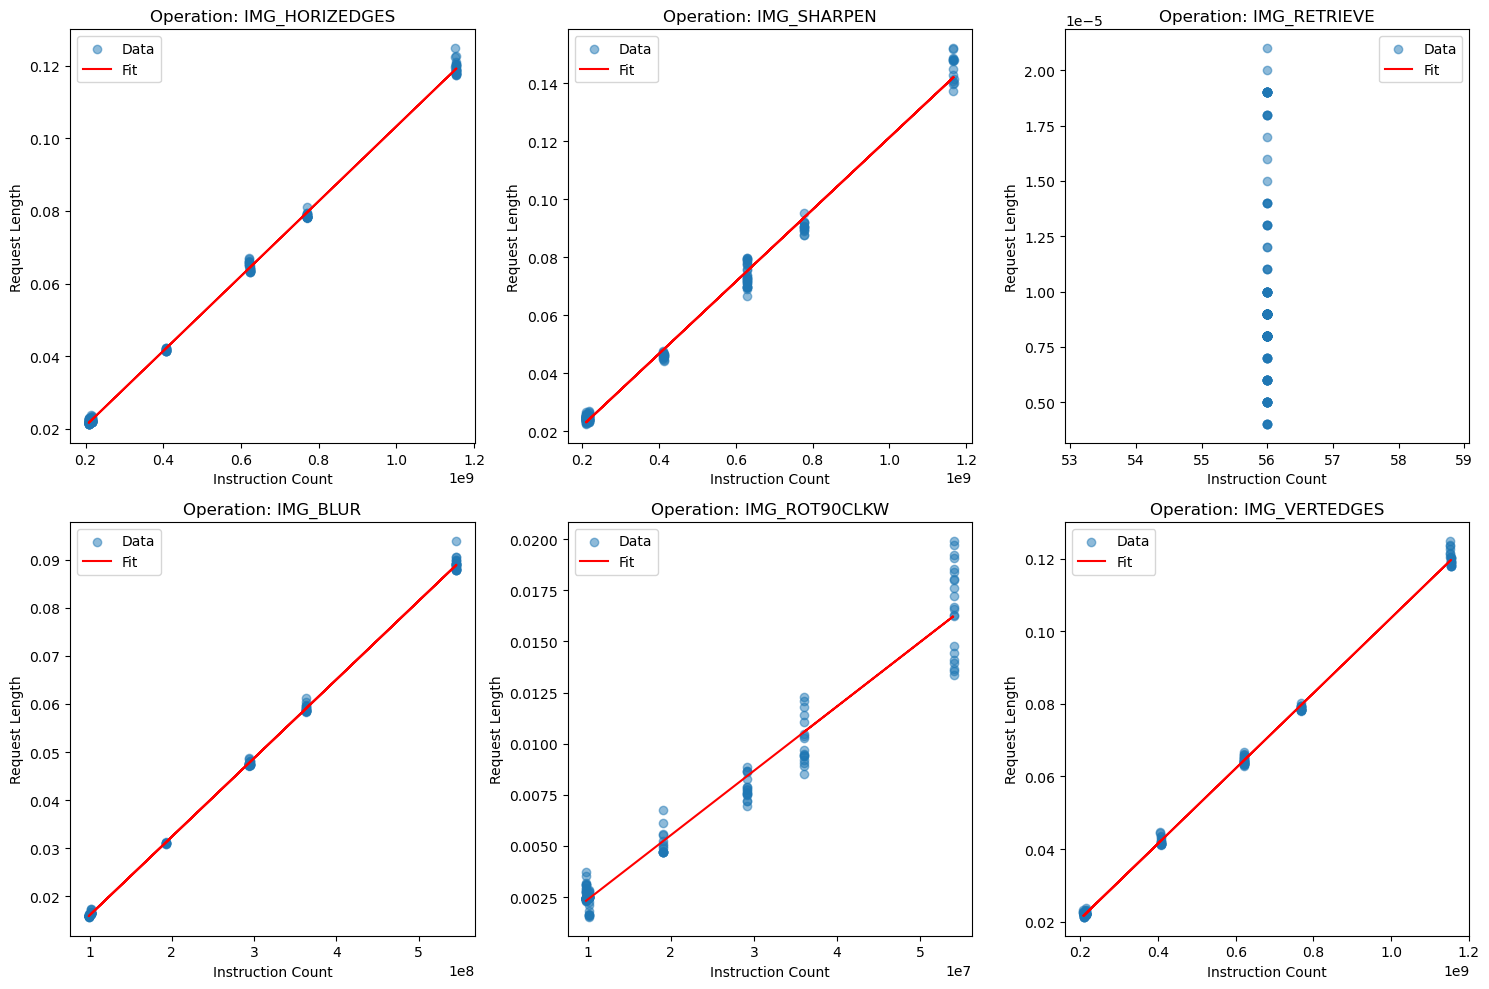

In [141]:
# Read log file
with open('./partA/output.txt', 'r') as file:
    log_lines = file.readlines()

data = []

# Define the pattern to match the log lines
pattern = (
    r"T(\d+) R(\d+):([\d.]+),([\w_]+),(\d+),(\d+),(\d+),([\d.]+),([\d.]+),([\d.]+),(\w+),(\d+)"
)

# Parse each line
for line in log_lines:
    match = re.match(pattern, line)
    if match:
        data.append(match.groups())

# Create a DataFrame
df = pd.DataFrame(data, columns=[
    'thread_id', 'req_id', 'req_timestamp', 'img_op', 'overwrite',
    'client_img_id', 'server_img_id', 'receipt_timestamp', 'start_timestamp',
    'completion_timestamp', 'event_name', 'event_count'
])

# Convert data types
df['req_id'] = df['req_id'].astype(int)
df['req_timestamp'] = df['req_timestamp'].astype(float)
df['overwrite'] = df['overwrite'].astype(int)
df['client_img_id'] = df['client_img_id'].astype(int)
df['server_img_id'] = df['server_img_id'].astype(int)
df['receipt_timestamp'] = df['receipt_timestamp'].astype(float)
df['start_timestamp'] = df['start_timestamp'].astype(float)
df['completion_timestamp'] = df['completion_timestamp'].astype(float)
df['event_count'] = df['event_count'].astype(int)

# Calculate request length
df['request_length'] = df['completion_timestamp'] - df['start_timestamp']

# Create plots for each image operation
operations = df['img_op'].unique()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, op in enumerate(operations):
    op_data = df[df['img_op'] == op]
    x = op_data['event_count'].values.reshape(-1, 1)
    y = op_data['request_length']

    # Perform linear regression
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)

    # Plot
    ax = axs[i // 3, i % 3]
    ax.scatter(x, y, alpha=0.5, label='Data')
    ax.plot(x, y_pred, color='red', label='Fit')
    ax.set_title(f'Operation: {op}')
    ax.set_xlabel('Instruction Count')
    ax.set_ylabel('Request Length')
    ax.legend()

plt.tight_layout()
plt.show()

The operations `IMG_HORIZEDGES`, `IMG_SHARPEN`, `IMG_BLUR`, `IMG_ROT90CLKW`, AND `IMG_VERTEDGES` have a strong linear relationship between instruction count and request length. The line of best fit closely follows the data points, indicating that as the instruction count increases, the request length also increases proportionally. The `IMG_RETRIEVE` operation seems to have a constant instruction count regardless of request length, possibly due to its nature not involving complex computations like other operations.

The slopes of the lines vary among operations, suggesting different computational complexities. For example, `IMG_ROT90CLKW` appears to have a smaller slope compared to the others, indicating it might be less instruction-intensive per unit of request length. 

The lack of variation for `IMG_RETRIEVE` suggests it's not significantly impacted by the factors affecting other operations. System variability such as different system loads during execution could affect timing. It can be also due to caching mechanisms and differences in hardware such as the CPU architecture. 

-----
b) For this part, we now want to observe LLC Cache Misses as we either perform random requests, or perform operations on the same image in succession.

To do this, we will use the `-L` functionality of the client in order to specify a very specific request script. In this request script, we dictate to the client exactly which image operations we want it to request.

Run the following experiment for RUN1:

`./server_img_perf -q 1500 -w 1 -h LLCMISS 2222 & ./client 2222 -I ./images/ \ -L <SCRIPT>`

The `<SCRIPT>` will be comprised of two parts: (1) Intro, (2) Ops. The Intro will not change, but we will re-order the Ops section of the script across two runs. Be careful about not omitting the comma “,”at the end of these pieces when concatenating Intro and Ops.

(1) Intro (register 5 images):

`0:R:1:0,0:R:1:1,0:R:1:2,0:R:1:3,0:R:1:4,`

(2) Ops (repeating pattern):

`0:r:1:0,0:r:1:0,0:r:1:0,0:r:1:0,0:r:1:0,0:b:1:0,0:b:1:0,0:b:1:0,0:b:1:0,\
0:b:1:0,0:s:1:0,0:s:1:0,0:s:1:0,0:s:1:0,0:s:1:0,0:v:1:0,0:v:1:0,0:v:1:0,\
0:v:1:0,0:v:1:0,0:h:1:0,0:h:1:0,0:h:1:0,0:h:1:0,0:h:1:0,0:r:1:1,0:r:1:1,\
0:r:1:1,0:r:1:1,0:r:1:1,0:b:1:1,0:b:1:1,0:b:1:1,0:b:1:1,0:b:1:1,0:s:1:1,\
0:s:1:1,0:s:1:1,0:s:1:1,0:s:1:1,0:v:1:1,0:v:1:1,0:v:1:1,0:v:1:1,0:v:1:1,\
0:h:1:1,0:h:1:1,0:h:1:1,0:h:1:1,0:h:1:1,0:r:1:2,0:r:1:2,0:r:1:2,0:r:1:2,\
0:r:1:2,0:b:1:2,0:b:1:2,0:b:1:2,0:b:1:2,0:b:1:2,0:s:1:2,0:s:1:2,0:s:1:2,\
0:s:1:2,0:s:1:2,0:v:1:2,0:v:1:2,0:v:1:2,0:v:1:2,0:v:1:2,0:h:1:2,0:h:1:2,\
0:h:1:2,0:h:1:2,0:h:1:2,0:r:1:3,0:r:1:3,0:r:1:3,0:r:1:3,0:r:1:3,0:b:1:3,\
0:b:1:3,0:b:1:3,0:b:1:3,0:b:1:3,0:s:1:3,0:s:1:3,0:s:1:3,0:s:1:3,0:s:1:3,\
0:v:1:3,0:v:1:3,0:v:1:3,0:v:1:3,0:v:1:3,0:h:1:3,0:h:1:3,0:h:1:3,0:h:1:3,\
0:h:1:3,0:r:1:4,0:r:1:4,0:r:1:4,0:r:1:4,0:r:1:4,0:b:1:4,0:b:1:4,0:b:1:4,\
0:b:1:4,0:b:1:4,0:s:1:4,0:s:1:4,0:s:1:4,0:s:1:4,0:s:1:4,0:v:1:4,0:v:1:4,\
0:v:1:4,0:v:1:4,0:v:1:4,0:h:1:4,0:h:1:4,0:h:1:4,0:h:1:4,0:h:1:4`

Notice that RUN1 will perform a variety of operations on different images, but grouped so that all operations of the same type/image are performed one after the other.

Now, for RUN2, switch the Ops, section of the client SCRIPT to the following:

(2) Ops (repeating pattern):

`0:s:1:2,0:r:1:3,0:s:1:4,0:b:1:4,0:s:1:1,0:b:1:0,0:v:1:1,0:b:1:4,0:b:1:1,0:h:1:0,\
0:v:1:2,0:r:1:1,0:s:1:0,0:b:1:3,0:v:1:4,0:r:1:0,0:v:1:1,0:v:1:4,0:r:1:4,0:s:1:4,\
0:s:1:4,0:r:1:0,0:s:1:3,0:h:1:4,0:s:1:1,0:v:1:3,0:v:1:2,0:s:1:1,0:h:1:3,0:h:1:3,\
0:v:1:0,0:h:1:0,0:r:1:2,0:b:1:3,0:v:1:2,0:b:1:1,0:h:1:2,0:v:1:3,0:b:1:4,0:v:1:3,\
0:r:1:3,0:r:1:2,0:v:1:2,0:b:1:2,0:r:1:2,0:h:1:1,0:b:1:3,0:h:1:1,0:r:1:1,0:b:1:0,\
0:h:1:3,0:s:1:0,0:h:1:2,0:v:1:0,0:v:1:3,0:r:1:4,0:v:1:1,0:s:1:0,0:v:1:3,0:r:1:0,\
0:h:1:0,0:s:1:1,0:v:1:4,0:s:1:2,0:v:1:0,0:r:1:4,0:s:1:0,0:v:1:4,0:b:1:0,0:h:1:3,\
0:r:1:1,0:b:1:2,0:h:1:1,0:s:1:3,0:b:1:3,0:h:1:1,0:r:1:4,0:s:1:0,0:h:1:4,0:b:1:3,\
0:b:1:1,0:h:1:4,0:r:1:4,0:b:1:1,0:r:1:1,0:s:1:1,0:b:1:2,0:h:1:2,0:b:1:0,0:r:1:0,\
0:v:1:0,0:b:1:4,0:s:1:3,0:b:1:0,0:b:1:1,0:r:1:3,0:h:1:4,0:h:1:0,0:h:1:1,0:v:1:1,\
0:b:1:2,0:s:1:3,0:r:1:2,0:v:1:4,0:v:1:0,0:r:1:3,0:s:1:2,0:v:1:2,0:r:1:3,0:h:1:3,\
0:h:1:2,0:s:1:2,0:h:1:0,0:h:1:4,0:v:1:1,0:s:1:4,0:s:1:3,0:h:1:2,0:r:1:1,0:s:1:2,\
0:r:1:2,0:r:1:0,0:b:1:4,0:s:1:4,0:b:1:2`

Notice that RUN2 performs the exact same operations as RUN1 but shuffled randomly.

Post process the outputs from RUN1 and RUN2 and for each run, produce a plot of the CDF (as we did in HW5/HW6) of the number of LL cache misses caused by each operation. Additionally, include a vertical bar marking the average number of LLC misses for each run.

Plot both CDF lines on the same plot for ease of comparison in two different colors.

Also, report and compare the MIN and MAX LL cache miss for each run.
(1) Do you notice any differences between the CDFs of two runs? What about the MIN/MAX LL cache misses? Why might these differences occur? (2) What can you say about the statefullness of the
resources in our image server?

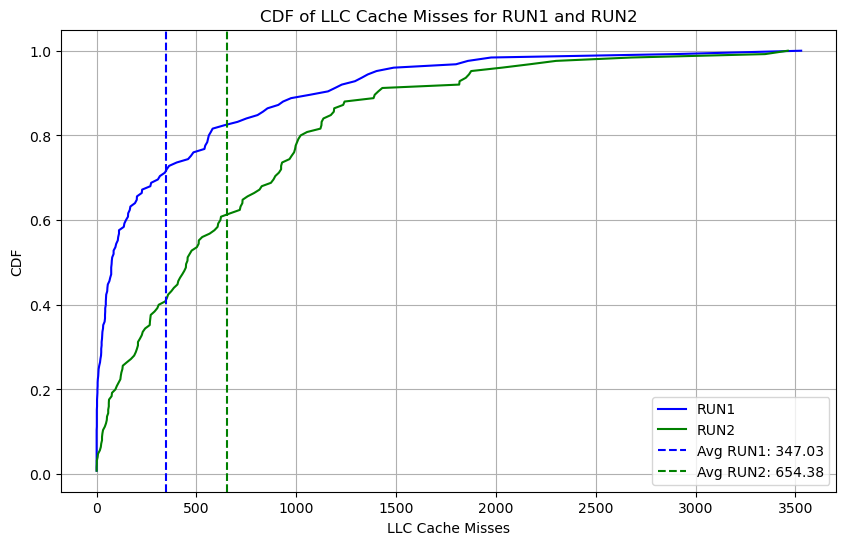

RUN1 - Min: 0, Max: 3529
RUN2 - Min: 0, Max: 3462


In [142]:
# Parse the log file and extract LLC cache misses
def parse_log_file(filename):
	llc_misses = []
	with open(filename, 'r') as file:
		for line in file:
			match = re.search(r'LLCMISS,(\d+)', line)
			if match:
				llc_misses.append(int(match.group(1)))
	return llc_misses

# Read LLC cache misses from the files
llc_misses_run1 = parse_log_file('./partB/run1.txt')
llc_misses_run2 = parse_log_file('./partB/run2.txt')

# Convert to DataFrame
df_run1 = pd.DataFrame({'llc_misses': llc_misses_run1})
df_run2 = pd.DataFrame({'llc_misses': llc_misses_run2})

# Sort data
df_run1 = df_run1.sort_values('llc_misses')
df_run2 = df_run2.sort_values('llc_misses')

# Calculate CDF
cdf_run1 = np.arange(1, len(df_run1) + 1) / len(df_run1)
cdf_run2 = np.arange(1, len(df_run2) + 1) / len(df_run2)

# Plot CDFs
plt.figure(figsize=(10, 6))
plt.plot(df_run1['llc_misses'], cdf_run1, label='RUN1', color='blue')
plt.plot(df_run2['llc_misses'], cdf_run2, label='RUN2', color='green')

# Plot average LLC misses
avg_run1 = np.mean(llc_misses_run1)
avg_run2 = np.mean(llc_misses_run2)
plt.axvline(avg_run1, color='blue', linestyle='--', label=f'Avg RUN1: {avg_run1:.2f}')
plt.axvline(avg_run2, color='green', linestyle='--', label=f'Avg RUN2: {avg_run2:.2f}')

# Set plot labels and title
plt.xlabel('LLC Cache Misses')
plt.ylabel('CDF')
plt.title('CDF of LLC Cache Misses for RUN1 and RUN2')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Report MIN and MAX LLC cache misses
min_run1, max_run1 = np.min(llc_misses_run1), np.max(llc_misses_run1)
min_run2, max_run2 = np.min(llc_misses_run2), np.max(llc_misses_run2)

print(f'RUN1 - Min: {min_run1}, Max: {max_run1}')
print(f'RUN2 - Min: {min_run2}, Max: {max_run2}')

RUN1 shows a steeper rise early on, indicating that a higher proportion of operations have lower cache misses. This suggests better cache utilization. RUN2 has a more gradual increase, indicating more variation and generally higher cache misses across operations. 

RUN1 has lower average cache misses. RUN2 has a higher average, suggesting that the random order of operations led to increased cache misses. RUN1 likely has lower minimum and maximum cache misses due to sequential, grouped operations that better utilize cache locality. RUN2 has higher minimum and maximum misses, likely due to randomized operations that disrupt cache locality. 

Possible reasons for the differences could be that RUN1's grouped operations likely benefit from better cache locality, reducing cache misses. While RUN2's random order leads to frequent cache evictions and reloads, increasing misses.

The differences suggests that the image server's performance is influenced by the statefulness of its resources. Efficient cache usage in RUN1 indicates that the server maintains state in a way that benefits from predictable access patterns. 

-----
c) Now, we wish to observe L1 cache misses across two similar operations. Note: that the code for `imglib.c` has been modified slightly from the previous part. Be sure to analyze your image server with the latest imglib.c from the hw7 template.

Specifically, we will be isolating the results of the `IMG_BLUR` and `IMG_SHARPEN` image operations.

Run the command:

`./build/server_img_perf -q 1000 -h L1MISS 2222 & ./build/client -a 30 -I images/ -n 1000 2222`
Now on one plot, plot two distributions. In one color, plot the distribution of `L1MISS` counted from `IMG_BLUR` operations and in another color plot the distribution of L1MISS counted from IMG_SHARPEN
operations.

To do so, isolate the reported counts from these two types of operations and split them into two datasets. With each, produce a plot of the distribution of `L1MISS` counts you have collected. The distribution plot should have on the x-axis a set of `L1MISS` count bins, e.g., from 0 (included) to 500 (excluded), from 500 (included) to 1000 (excluded), and so on in steps of 500 increments. However, you will need to find the appropriate bin size to visulize your data.

Given each transaction, look at its reported `L1MISS` count. On the y-axis, plot how many requests fall in each bin! But do not plot the raw count. Rather, normalize that value by the total number of
requests you are plotting. As in HW2, you have produced a distribution plot (however, not of request lengths, now instead, of the result of our counter).

(1) What do you notice about the distribution of `L1MISS` counts of `IMG_BLUR` and `IMG_SHARPEN`? How do they differ? (2) If you are using the new image library, you should see a significant difference.
Go to `imglib.c`, and inspect the implementation of `blurImage()` and `sharpenImage()`. What could be causing these two functions, which perform similar operations, to have vastly different L1 cache
behaviours? Provide a suggestion on how to improve the operation with more L1 cache misses.

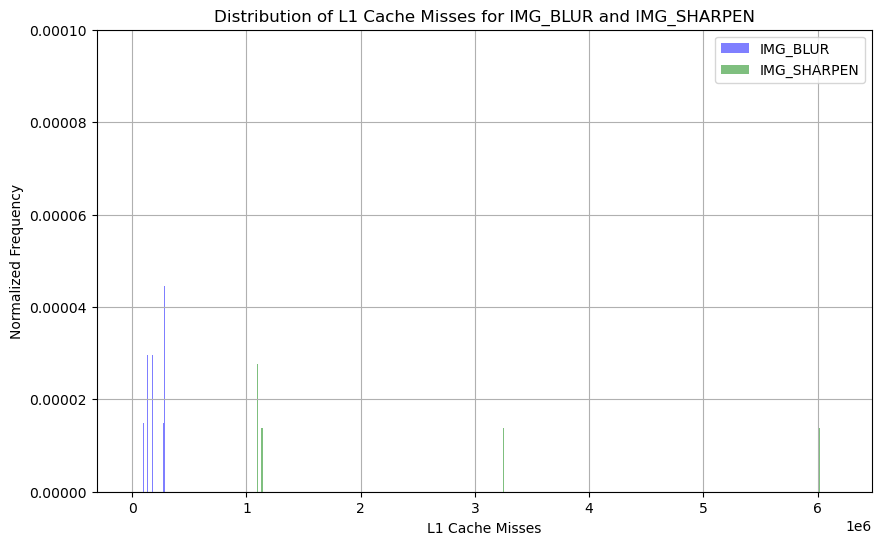

In [143]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Parse the log file and extract L1 cache misses
def parse_log_file(filename):
    blur_misses = []
    sharpen_misses = []
    with open(filename, 'r') as file:
        for line in file:
            if 'IMG_BLUR' in line:
                match = re.search(r'L1MISS,(\d+)', line)
                if match:
                    blur_misses.append(int(match.group(1)))
            elif 'IMG_SHARPEN' in line:
                match = re.search(r'L1MISS,(\d+)', line)
                if match:
                    sharpen_misses.append(int(match.group(1)))
    return blur_misses, sharpen_misses

# Read the L1 cache misses from the file
blur_misses, sharpen_misses = parse_log_file('./partC/output.txt')

# Determine appropriate bin size
max_miss = max(max(blur_misses), max(sharpen_misses))
bins = np.arange(0, max_miss + 500, 500)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(blur_misses, bins=bins, alpha=0.5, label='IMG_BLUR', color='blue', density=True)
plt.hist(sharpen_misses, bins=bins, alpha=0.5, label='IMG_SHARPEN', color='green', density=True)

# Set plot labels and title
plt.xlabel('L1 Cache Misses')
plt.ylabel('Normalized Frequency')
plt.title('Distribution of L1 Cache Misses for IMG_BLUR and IMG_SHARPEN')
plt.legend()
plt.grid(True)

# Show plot
plt.ylim(0, 0.0001)
plt.show()

For the distribution differences, `IMG_BLUR` shows a lower range of L1 cache misses, indicating the operation is generally more cache-efficient. `IMG_SHARPEN` exhibits a wider spread and higher L1 cache misses. The `IMG_SHARPEN` operation has more cache misses, which suggests less efficient cache usage. 

Upon inspecting the code, `blurImage()` uses a simple averaging kernel and accesses neighboring pixels in a straightforward manner. This can lead to more predictable memory access patterns, benefitting cache locality. `sharpenImage` applies a sharpening kernel with negative weights, which might cause more scattered memory access, leading to higher cache misses. 

Potential causes could be the kernel weights, with the sharpening operation involving more complex calculations and different memory access patterns. The loop order in which the order of the loops (x vs. y first) and kernel application can also affect cache performance.

Suggestions for improvement could be to optimize the loop order, ensuring that the innermost loop processes elements sequentially in memory to improve cache hits. You can also ensure both functions access data in a row-major order to improve cache locality. Loop unrolling or tiling techniques can also be used to enhance data reuse and reduce cache misses. 